In [3]:
import pandas as pd
metadata_df = pd.read_csv("./HAM10000_metadata")

In [19]:
import os
import shutil

# Define the main directory where you want to store the organized images
main_directory = './dataset/train'

# Define the directories where your images are currently located
image_directories = ['./HAM10000_images_part_1', './HAM10000_images_part_2']

# Identify unique classes in the 'dx' column
unique_classes = metadata_df['dx'].unique()

# Create a directory for each unique class
for class_label in unique_classes:
    class_directory = os.path.join(main_directory, class_label)
    os.makedirs(class_directory, exist_ok=True)

# Iterate over the metadata DataFrame and move each image to the corresponding class directory
for index, row in metadata_df.iterrows():
    image_id = row['image_id']
    class_label = row['dx']
    
    # Define destination path
    destination_path = os.path.join(main_directory, class_label, f"{image_id}.jpg")
    
    # Check both source folders for the image
    for image_directory in image_directories:
        source_path = os.path.join(image_directory, f"{image_id}.jpg")
        
        # If the source path exists, move the image and break out of the loop
        if os.path.exists(source_path):
            shutil.copy(source_path, destination_path)
            break


In [21]:
# splitting validation set
import os
import shutil
from sklearn.model_selection import train_test_split
train_dir = './dataset/train'
val_dir = './dataset/validation'

if not os.path.exists(val_dir):
    os.makedirs(val_dir)
for class_name in os.listdir(train_dir):
    # Define class-specific directories for train and validation sets
    class_train_dir = os.path.join(train_dir, class_name)
    class_val_dir = os.path.join(val_dir, class_name)
    
    # Get the list of image filenames for the class
    images = os.listdir(class_train_dir)
    
    # Split the list of images into training and validation subsets
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)  # 20% of data to validation set
    
    # If the class-specific validation directy does not exist, create it
    if not os.path.exists(class_val_dir):
        os.makedirs(class_val_dir)
    
    # Move the validation images to the validation directory
    for img in val_images:
        src = os.path.join(class_train_dir, img)
        dst = os.path.join(class_val_dir, img)
        shutil.move(src, dst)

        

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the training generator with data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rotation_range=20,        # rotate the image 20 degrees
    width_shift_range=0.1,    # Shift the pic width by a max of 10%
    height_shift_range=0.1,   # Shift the pic height by a max of 10%
    shear_range=0.1,          # Shear means cutting away part of the image (max 10%)
    zoom_range=0.2,           # Zoom in by 20% max
    horizontal_flip=True,     # Allow horizontal flipping
    fill_mode='nearest'       # Fill in missing pixels with the nearest filled value
)


# Define the validation generator with only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    "./dataset/train", # path to the training data directory
    target_size=(128 , 128), # dimensions to which all images will be resized
    batch_size=15, 
    class_mode='categorical' # or 'categorical' based on your problem
)

val_generator = val_datagen.flow_from_directory(
    "./dataset/validation", # path to the validation data directory
    target_size=(128,128), 
    batch_size=15, 
    class_mode='categorical' # or 'categorical' based on your problem
)


Found 8010 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.


In [43]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_12 (Ba  (None, 126, 126, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_13 (Ba  (None, 61, 61, 64)       

/var/folders/jw/1n94bt095gvd97f9yxx9w8n80000gn/T/ipykernel_2261/221244343.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  quick_history = model.fit_generator(


Epoch 1/2
534/534 [==============================] - 158s 294ms/step - loss: 1.4032 - accuracy: 0.6009 - val_loss: 3.2550 - val_accuracy: 0.6677
Epoch 2/2
534/534 [==============================] - 160s 299ms/step - loss: 0.9906 - accuracy: 0.6588 - val_loss: 3.2717 - val_accuracy: 0.6702


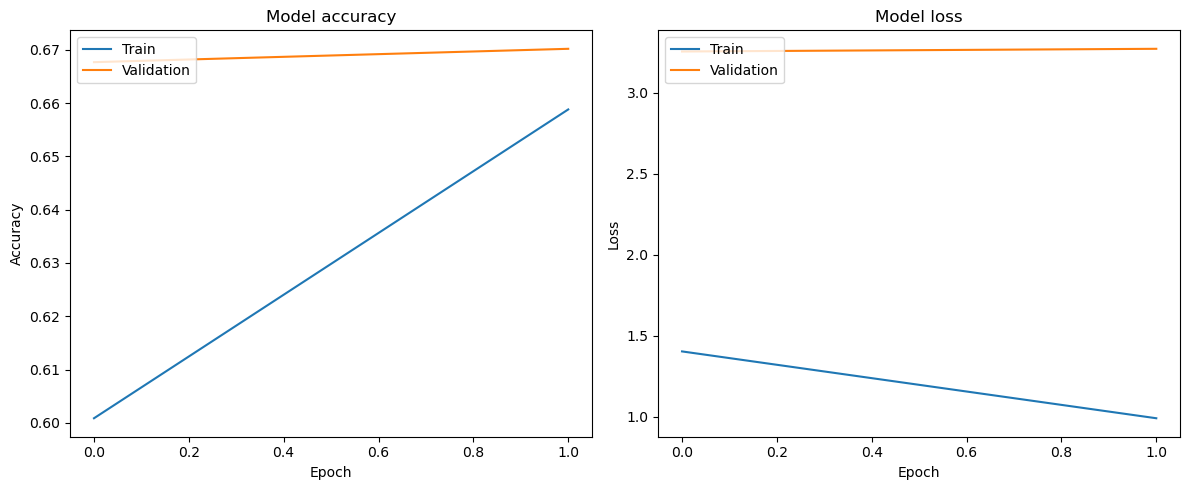

In [44]:
from tensorflow.keras.optimizers.legacy import Adam
quick_epochs = 2  # A small number of epochs
quick_lr = 0.01   # A larger learning rate
total_train = len(train_generator.filenames)
total_val = len(val_generator.filenames)

model.compile(optimizer=Adam(learning_rate=quick_lr), loss='categorical_crossentropy', metrics=['accuracy'])

quick_history = model.fit_generator(
    train_generator,
    steps_per_epoch=total_train // 15,
    epochs=quick_epochs,
    validation_data=val_generator,
    validation_steps=total_val // 15,
)
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(quick_history.history['accuracy'])
plt.plot(quick_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(quick_history.history['loss'])
plt.plot(quick_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()